In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yfinance import download
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from scipy.stats import shapiro, ttest_ind, skew, kurtosis
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Error Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif




In [2]:
#pip install pandas_datareader

In [3]:
#pip install pandas numpy matplotlib scikit-learn yfinance

Loading and Inspecting Data

In [5]:
df= pd.read_csv('2010_2025_Tesla Stock Price History.csv')

In [6]:
import yfinance as yf

In [7]:
#tesla = yf.download("TSLA")
#df = yf.download(["TSLA"]);

In [8]:
#df = yf.download("TSLA", start="2010-06-29", end="2025-04-15")

In [9]:
#data = yf.download("TSLA")
#start_date = "2010-06-29"
#end_date = "2025-04-15"

In [10]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,04/15/2025,254.11,249.91,258.75,247.54,79.59M,0.70%
1,04/14/2025,252.35,258.36,261.80,245.93,100.14M,0.02%
2,04/11/2025,252.31,251.84,257.74,241.36,128.95M,-0.04%
3,04/10/2025,252.40,260.00,262.49,239.33,181.72M,-7.27%
4,04/09/2025,272.20,224.69,274.69,223.88,219.43M,22.69%


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3722 entries, 0 to 3721
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3722 non-null   object 
 1   Price     3722 non-null   float64
 2   Open      3722 non-null   float64
 3   High      3722 non-null   float64
 4   Low       3722 non-null   float64
 5   Vol.      3722 non-null   object 
 6   Change %  3722 non-null   object 
dtypes: float64(4), object(3)
memory usage: 203.7+ KB


In [12]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,04/15/2025,254.11,249.91,258.75,247.54,79.59M,0.70%
1,04/14/2025,252.35,258.36,261.80,245.93,100.14M,0.02%
2,04/11/2025,252.31,251.84,257.74,241.36,128.95M,-0.04%
3,04/10/2025,252.40,260.00,262.49,239.33,181.72M,-7.27%
4,04/09/2025,272.20,224.69,274.69,223.88,219.43M,22.69%


In [13]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3717,07/07/2010,1.05,1.09,1.11,1.00,103.87M,-1.87%
3718,07/06/2010,1.07,1.33,1.33,1.06,103.19M,-16.41%
3719,07/02/2010,1.28,1.53,1.54,1.25,77.13M,-12.33%
3720,07/01/2010,1.46,1.67,1.73,1.35,123.45M,-8.18%
3721,06/30/2010,1.59,1.72,2.03,1.55,257.92M,0.00%


In [14]:
df.shape

(3722, 7)

Preparation Data

In [16]:
# To before modeling , it needs to prepare (missing values, what is data types of featurs to conduct) 
 
print(df.isnull().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [17]:
# Type of values the features are. 

print(df.dtypes)

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object


In [18]:
#For easier modeilng is better to modify dataset - delete Tickers, 
#renaming Price in Date, "Date" is the index. 

df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
print(df.columns)

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


In [19]:
#  Date into datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Check for (Nan):
print(df[df['Date'].isna()])  


Empty DataFrame
Columns: [Date, Price, Open, High, Low, Vol., Change %]
Index: []


In [20]:

# 'Date' is really in datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter dates (from2010-06-29 to 2025-04-15)
df = df[(df['Date'] >= '2010-06-29') & (df['Date'] <= '2025-04-15')]

# Sorting
df = df.sort_values(by='Date', ascending=True)

# Chacke a fromat
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')


print(df.head())  
print(df.tail()) 

            Date  Price  Open  High   Low     Vol. Change %
3721  2010-06-30   1.59  1.72  2.03  1.55  257.92M    0.00%
3720  2010-07-01   1.46  1.67  1.73  1.35  123.45M   -8.18%
3719  2010-07-02   1.28  1.53  1.54  1.25   77.13M  -12.33%
3718  2010-07-06   1.07  1.33  1.33  1.06  103.19M  -16.41%
3717  2010-07-07   1.05  1.09  1.11  1.00  103.87M   -1.87%
         Date   Price    Open    High     Low     Vol. Change %
4  2025-04-09  272.20  224.69  274.69  223.88  219.43M   22.69%
3  2025-04-10  252.40  260.00  262.49  239.33  181.72M   -7.27%
2  2025-04-11  252.31  251.84  257.74  241.36  128.95M   -0.04%
1  2025-04-14  252.35  258.36  261.80  245.93  100.14M    0.02%
0  2025-04-15  254.11  249.91  258.75  247.54   79.59M    0.70%


In [21]:
df.head()

# As a reslut: now Date has become Index and other features are columns. 

,Date,Price,Open,High,Low,Vol.,Change %
3721,2010-06-30,1.59,1.72,2.03,1.55,257.92M,0.00%
3720,2010-07-01,1.46,1.67,1.73,1.35,123.45M,-8.18%
3719,2010-07-02,1.28,1.53,1.54,1.25,77.13M,-12.33%
3718,2010-07-06,1.07,1.33,1.33,1.06,103.19M,-16.41%
3717,2010-07-07,1.05,1.09,1.11,1.00,103.87M,-1.87%


In [22]:
print(df.dtypes)

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object


In [23]:
df = df.rename(columns={'Vol.': 'Volume'})  # rename

In [24]:
df = df.rename(columns={'Price': 'Close'})  # rename

In [25]:
#df = df.set_index('Date') 

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3722 entries, 3721 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3722 non-null   object 
 1   Close     3722 non-null   float64
 2   Open      3722 non-null   float64
 3   High      3722 non-null   float64
 4   Low       3722 non-null   float64
 5   Volume    3722 non-null   object 
 6   Change %  3722 non-null   object 
dtypes: float64(4), object(3)
memory usage: 232.6+ KB


In [27]:
#'Volume' object to numerical:
df['Volume'] = df['Volume'].astype(str).str.replace('M', '').astype(float) 

In [28]:
df.rename(columns={'Change %': 'Change%'}, inplace=True)   

In [29]:
print(df.head())

            Date  Close  Open  High   Low  Volume  Change%
3721  2010-06-30   1.59  1.72  2.03  1.55  257.92    0.00%
3720  2010-07-01   1.46  1.67  1.73  1.35  123.45   -8.18%
3719  2010-07-02   1.28  1.53  1.54  1.25   77.13  -12.33%
3718  2010-07-06   1.07  1.33  1.33  1.06  103.19  -16.41%
3717  2010-07-07   1.05  1.09  1.11  1.00  103.87   -1.87%


In [30]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 'coerce' insted of Nat

In [31]:
df.head()

,Date,Close,Open,High,Low,Volume,Change%
3721,2010-06-30,1.59,1.72,2.03,1.55,257.92,0.00%
3720,2010-07-01,1.46,1.67,1.73,1.35,123.45,-8.18%
3719,2010-07-02,1.28,1.53,1.54,1.25,77.13,-12.33%
3718,2010-07-06,1.07,1.33,1.33,1.06,103.19,-16.41%
3717,2010-07-07,1.05,1.09,1.11,1.00,103.87,-1.87%


In [32]:
df.isnull().sum()

Date       0
Close      0
Open       0
High       0
Low        0
Volume     0
Change%    0
dtype: int64

In [33]:
# What dataset is consistent (Statistics)

df.describe()

,Date,Close,Open,High,Low,Volume
count,3722,3722.000000,3722.000000,3722.000000,3722.000000,3722.000000
mean,2017-11-19 16:57:07.834497536,86.114473,86.149103,88.073732,84.077579,96.880548
min,2010-06-30 00:00:00,1.050000,1.080000,1.110000,1.000000,1.780000
25%,2014-03-12 06:00:00,12.332500,12.332500,12.590000,12.105000,49.657500
50%,2017-11-16 12:00:00,18.560000,18.550000,18.810000,18.270000,82.600000
75%,2021-08-01 06:00:00,186.425000,185.495000,189.597500,182.007500,122.520000
max,2025-04-15 00:00:00,479.860000,475.900000,488.540000,457.510000,914.080000
std,NaN,111.902767,112.013748,114.563686,109.186227,77.218952


The dataset contains 3722 daily records — this aligns well with the period from Tesla IPO (June 2010) to April 2025.

Price (Close):

Mean: $86, 
Median (50%): $18.56,
Max: $479.7
Min: $1.05
Standard deviation: $111.9 — very high, which indicates significatnliolai##-- ty.

Volume:
Mean dail volume: 96,9 mil1n
Min:  1,78 mion
Max:  914 million
Standard deviation very high (77.2 mllion)

It is  that:
Tesla trading volume varies wildly, which periods of intense mit could be happening
market interest, like after some news or product releases, or probably Elon Musk tweets.

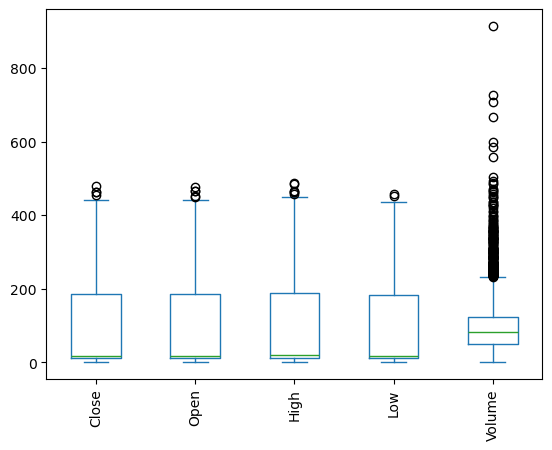

In [35]:
df.plot(kind='box', rot=90);

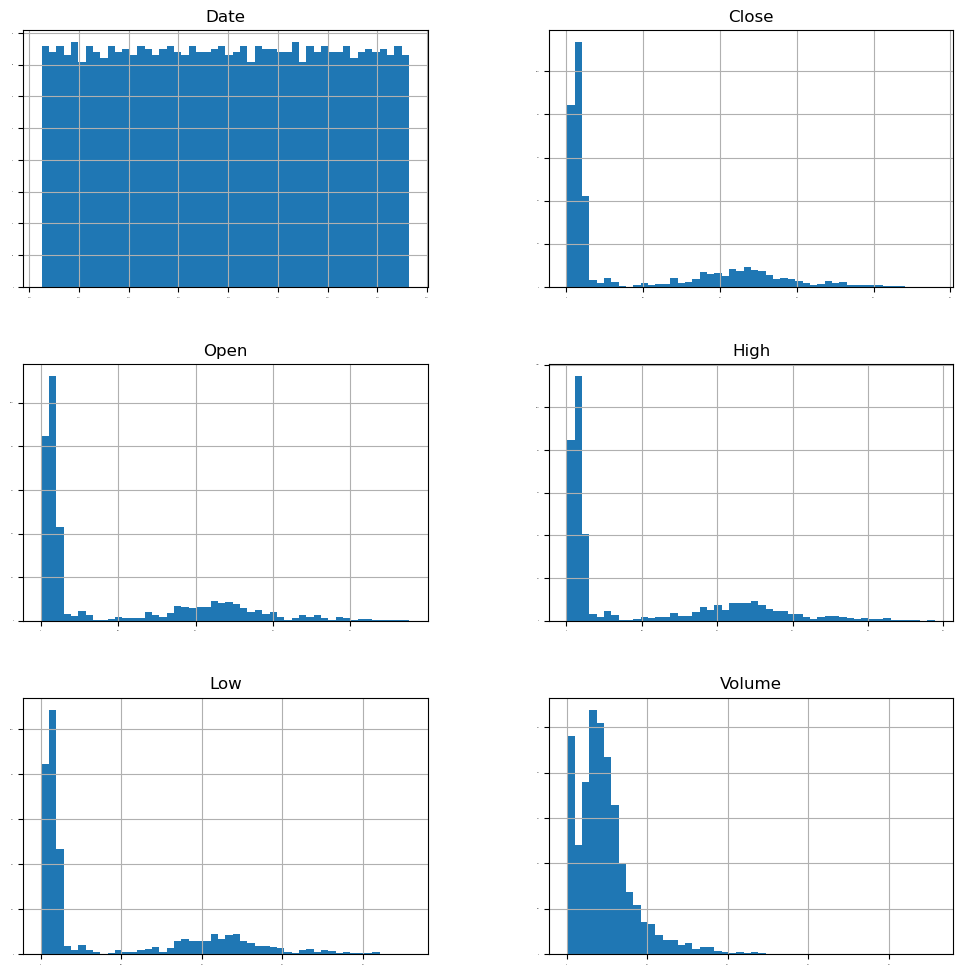

In [36]:
import matplotlib.pyplot as plt

df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

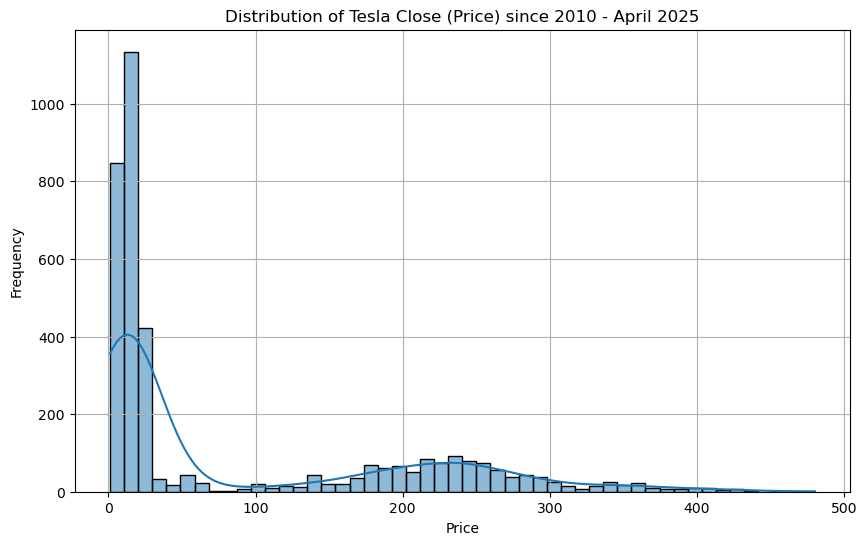

In [37]:

# Distribution of price since 2010 - April 2025
plt.figure(figsize=(10,6))
sns.histplot(df['Close'], kde=True, bins=50)
plt.title('Distribution of Tesla Close (Price) since 2010 - April 2025')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

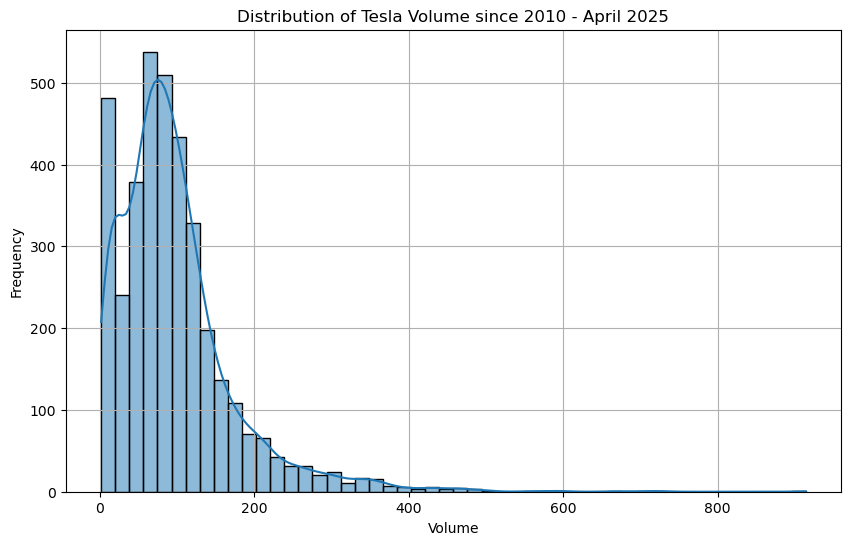

In [38]:
# Distribution of price since 2010 - April 2025
plt.figure(figsize=(10,6))
sns.histplot(df['Volume'], kde=True, bins=50)
plt.title('Distribution of Tesla Volume since 2010 - April 2025')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

For observing the full evolution of the company, where we can see the early stages, periods of growth, 
market cycles, and crises.
The period from the beginning of IPO Co gives to see the whole the model from real-world scenarios of growth, decline, and recovery.
More data - it can give better detection of long-term trends and the structure of seasonality.

In [40]:
#At the beginning -a plot of Close (Price) stock from the first day of IPO untill 15th April 2025

In [41]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [42]:
df.set_index('Date', inplace=True)

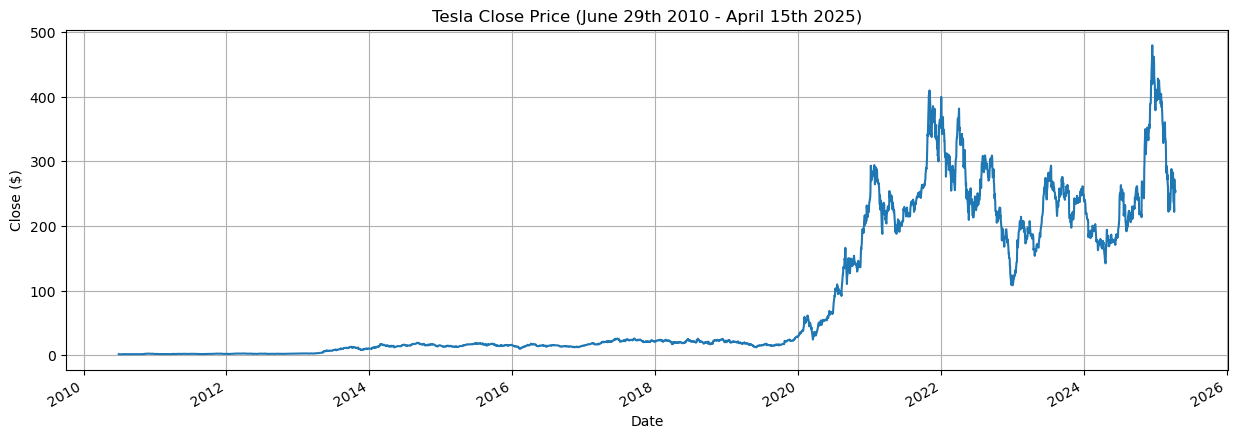

In [43]:
df['Close'].plot(figsize=(15,5), title='Tesla Close Price (June 29th 2010 - April 15th 2025)')
plt.xlabel('Date')
plt.ylabel('Close ($)')
plt.grid()
plt.show()

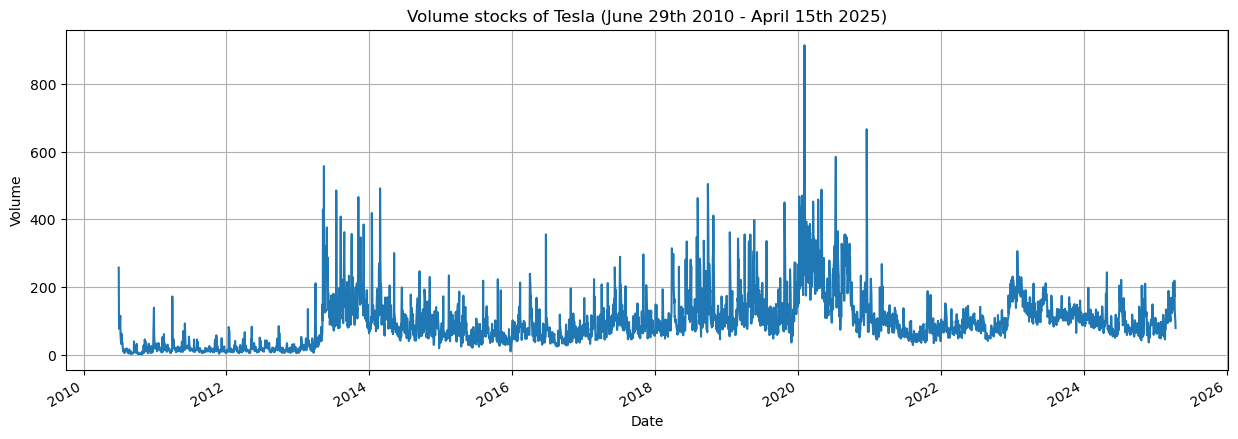

In [44]:


# Check and visualise a Volume trend 


df['Volume'].plot(figsize=(15,5), title='Volume stocks of Tesla (June 29th 2010 - April 15th 2025)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid()
plt.show()

As one of the essential tasks is to predict a price (Close) for Tesla for next April 2026, let's model at the beginning the Close. 

Being able to analyse a Tesla stock and how it performs via ARIMA or ARMA, SARIMA models and 
finally predict the price for next 2026 we need to learn the followng factors:

Trend,
Seasonality,
Ciclicity,
Resudials 
And finally, based on all of that to make a determination of a Series Time.



it is crucial to carefully analyze the key time series components:

Trend:
Detecting the long-term movement of Tesla’s stock price over the years, such as periods of steady growth, corrections, or plateau phases.
Tesla has a strong upward and curently  downward trends. 
#Upward trend we saw after a major event like product launching EV truck. 
Downward trend we can observe in current days when E.Mask is heading DOGE and EV cars are boycotted do not buy in entrire world. 

    
#Focus on 'Close' price





In [47]:
df.head()

,Close,Open,High,Low,Volume,Change%
Date,,,,,,
2010-06-30,1.59,1.72,2.03,1.55,257.92,0.00%
2010-07-01,1.46,1.67,1.73,1.35,123.45,-8.18%
2010-07-02,1.28,1.53,1.54,1.25,77.13,-12.33%
2010-07-06,1.07,1.33,1.33,1.06,103.19,-16.41%
2010-07-07,1.05,1.09,1.11,1.00,103.87,-1.87%


In [48]:
df.tail()

,Close,Open,High,Low,Volume,Change%
Date,,,,,,
2025-04-09,272.20,224.69,274.69,223.88,219.43,22.69%
2025-04-10,252.40,260.00,262.49,239.33,181.72,-7.27%
2025-04-11,252.31,251.84,257.74,241.36,128.95,-0.04%
2025-04-14,252.35,258.36,261.80,245.93,100.14,0.02%
2025-04-15,254.11,249.91,258.75,247.54,79.59,0.70%


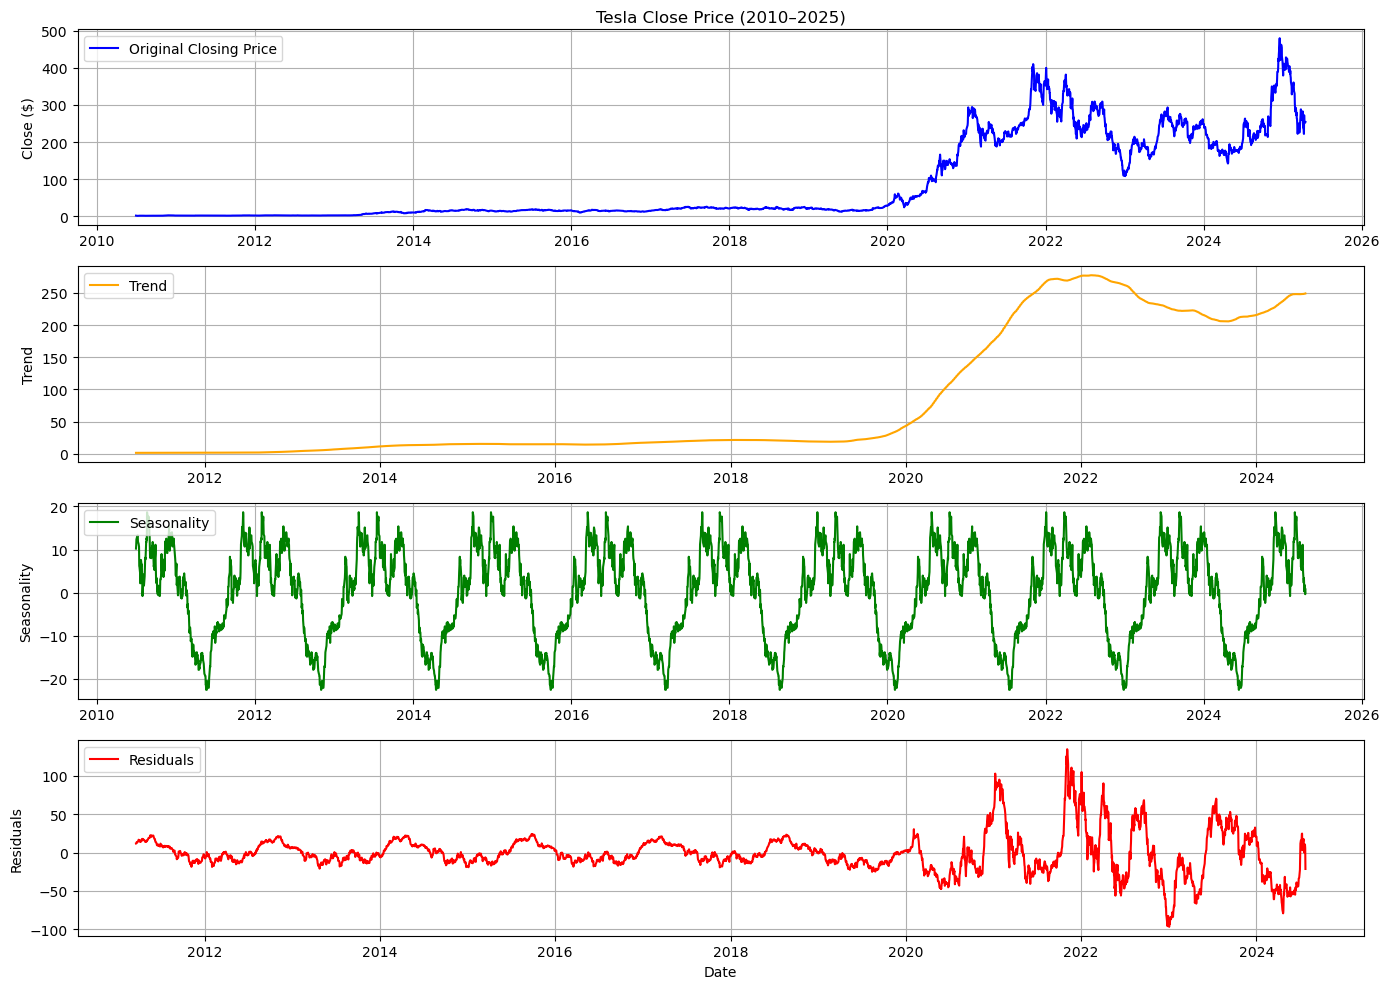

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose



# Decompose with a yearly seasonality assumption
result = seasonal_decompose(df['Close'], model='additive', period=365)

# Plot the components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(result.observed, label='Original Closing Price', color='blue')
plt.title('Tesla Close Price (2010–2025)')
plt.ylabel('Close ($)')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.ylabel('Trend')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality', color='green')
plt.ylabel('Seasonality')
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residuals', color='red')
plt.ylabel('Residuals')
plt.grid(True)
plt.legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()

Seasonality:
#It helps to identify repeating patterns that occur at regular intervals, such as quarterly financial reoprting effects, 
#earnings season impacts, or even market rallies, particularly at the end of year.

Cyclicality:
helps us to understand longer-term cycles that influence in cause of diverce economic factors like market booms or recessions.
In our case with Tesla it may reflect broader technology sector that we will observe later in this Juoyter Note in 
a sector of Clustering with S&P 500.  

Residuals:
After removing trend and seasonality we can still observe the irregular fluctuations 
that to must be checked and considered for precisional modelling.

In [51]:
print(df.index)
print(type(df.index))

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-07',
               '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11',
               '2025-04-14', '2025-04-15'],
              dtype='datetime64[ns]', name='Date', length=3722, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [52]:
print(df.columns)
print(df.head())

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change%'], dtype='object')
            Close  Open  High   Low  Volume  Change%
Date                                                
2010-06-30   1.59  1.72  2.03  1.55  257.92    0.00%
2010-07-01   1.46  1.67  1.73  1.35  123.45   -8.18%
2010-07-02   1.28  1.53  1.54  1.25   77.13  -12.33%
2010-07-06   1.07  1.33  1.33  1.06  103.19  -16.41%
2010-07-07   1.05  1.09  1.11  1.00  103.87   -1.87%


In [53]:
#df.index = pd.to_datetime(df.index, format='%m/%d/%Y')  # Convert correctly
#df = df.sort_index(ascending=False)  # Keep descending order (2025 → 2010)

In [54]:
print(df.index)

DatetimeIndex(['2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
               '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12',
               '2010-07-13', '2010-07-14',
               ...
               '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-07',
               '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11',
               '2025-04-14', '2025-04-15'],
              dtype='datetime64[ns]', name='Date', length=3722, freq=None)


In [55]:
df.index = pd.to_datetime(df.index, errors='coerce')  # Convert index to datetime format
df = df.sort_index(ascending=False)  # Keep descending order (2025 → 2010)

In [56]:
print(df.index.min(), df.index.max())  # Check dataset date range

2010-06-30 00:00:00 2025-04-15 00:00:00


In [57]:
df = df.dropna()  # Remove any invalid rows

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3722 entries, 2025-04-15 to 2010-06-30
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    3722 non-null   float64
 1   Open     3722 non-null   float64
 2   High     3722 non-null   float64
 3   Low      3722 non-null   float64
 4   Volume   3722 non-null   float64
 5   Change%  3722 non-null   object 
dtypes: float64(5), object(1)
memory usage: 203.5+ KB


In [59]:
df.isnull().sum()

Close      0
Open       0
High       0
Low        0
Volume     0
Change%    0
dtype: int64

In [60]:
print(df.loc["2025-02-19"])  # Test if this date exists
print(df.loc["2025-04-15"])  # Test if this date exists

Close      360.56
Open        354.0
High       367.34
Low        353.67
Volume      67.09
Change%     1.82%
Name: 2025-02-19 00:00:00, dtype: object
Close      254.11
Open       249.91
High       258.75
Low        247.54
Volume      79.59
Change%     0.70%
Name: 2025-04-15 00:00:00, dtype: object


In [61]:
df.index = pd.to_datetime(df.index, errors='coerce')  # Ensure correct datetime format
df = df.sort_index(ascending=True)  

In [62]:
print(df.index.min(), df.index.max())  # Check dataset date range
print("2025-02-19" in df.index)  # Check if start_date exists
print("2025-04-15" in df.index)  # Check if end_date exists

2010-06-30 00:00:00 2025-04-15 00:00:00
True
True


In [63]:
df.head(45)

,Close,Open,High,Low,Volume,Change%
Date,,,,,,
2010-06-30,1.59,1.72,2.03,1.55,257.92,0.00%
2010-07-01,1.46,1.67,1.73,1.35,123.45,-8.18%
2010-07-02,1.28,1.53,1.54,1.25,77.13,-12.33%
2010-07-06,1.07,1.33,1.33,1.06,103.19,-16.41%
2010-07-07,1.05,1.09,1.11,1.00,103.87,-1.87%
2010-07-08,1.16,1.08,1.17,1.04,115.79,10.48%
2010-07-09,1.16,1.17,1.19,1.10,60.88,0.00%
2010-07-12,1.14,1.20,1.20,1.13,33.05,-1.72%
2010-07-13,1.21,1.16,1.24,1.13,40.20,6.14%


In [64]:
start_date = pd.Timestamp("2025-02-19")
end_date = pd.Timestamp("2025-04-15")

df_decomposition = df.loc[start_date:end_date]  # Match descending order
print(df_decomposition.shape[0])  # Check if data is correctly selected

40


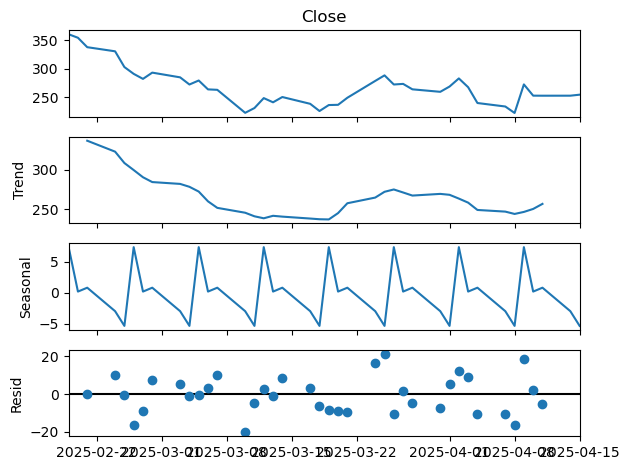

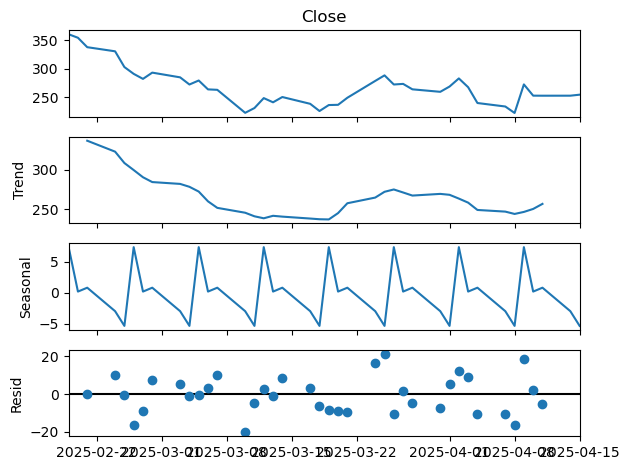

In [65]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df_decomposition['Close'], model='additive', period=5)# decomposition 
decomposition.plot()

Series Time/ Hypothesis Stationary

ADF Test for Stationarity

ADF test is a common statistical test used to test whether a given Time Series is Stationary or not. It is one of most commonly used statistical test when it comes to analyzing the stationarity of a series.

Null Hypothesis :- The Time Series is not stationary.

Alternate Hypothesis :- The Time series is stationary.

p-value > 0.05 :- Fails to reject null hypothesis, the data has a unit root and not stationary.

p-value < 0.05 :- Reject null hypothesis, the ata does not have a unit root and is stationary

In [68]:
from statsmodels.tsa.stattools import adfuller

# Check missing values in Date
df_filtered = df.dropna()

#  ADF test
result = adfuller(df_filtered['Close'])

# Print result
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Interpritation
if result[1] < 0.05:
    print("Stariinary (p-value < 0.05). Apply ARIMA without difernce.")
else:
    print("No Stationary (p-value > 0.05). Needs to apply differnce.")

ADF Statistic: -1.4071852842843595
p-value: 0.5788265963726316
No Stationary (p-value > 0.05). Needs to apply differnce.


In [69]:
print(type(df['Close']))  # <- Series / DataFrame?

<class 'pandas.core.series.Series'>


In [70]:
df_diff = df.dropna()
df_diff['Close'] = df_diff['Close'].diff().dropna()

In [71]:
# Take the difference
# First difference (with pandas)
df_diff = df[['Close']].copy()
df_diff['Close'] = df_diff['Close'].diff()
df_diff = df_diff.dropna()


In [72]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df_diff['Close'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -11.068614695326609
p-value: 4.613655594264668e-20


In [73]:
#ADF_result = adfuller(df_diff) 

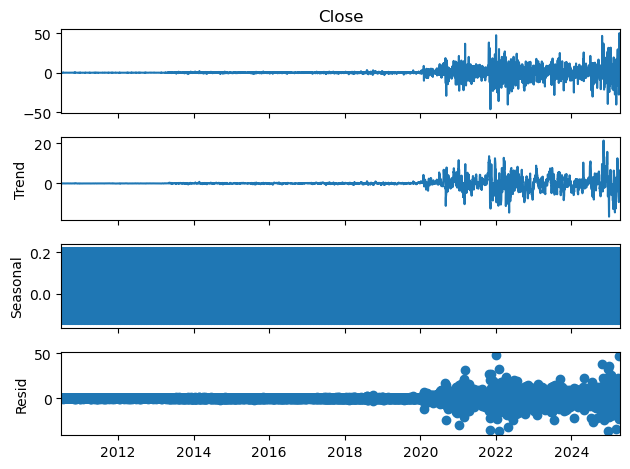

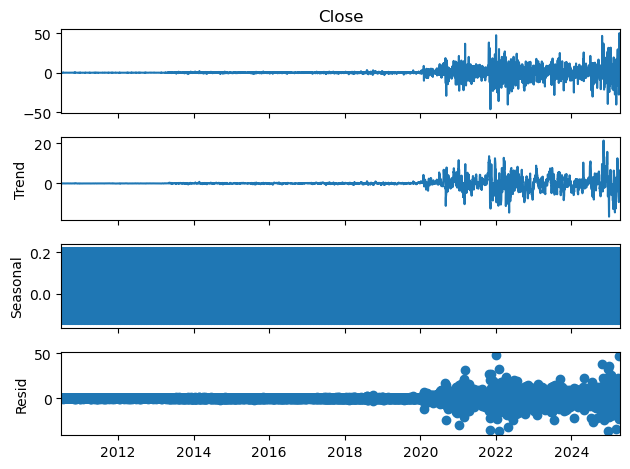

In [74]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_diff['Close'], model='addictive', period=5) # 5 Traiding days 
decomposition.plot()

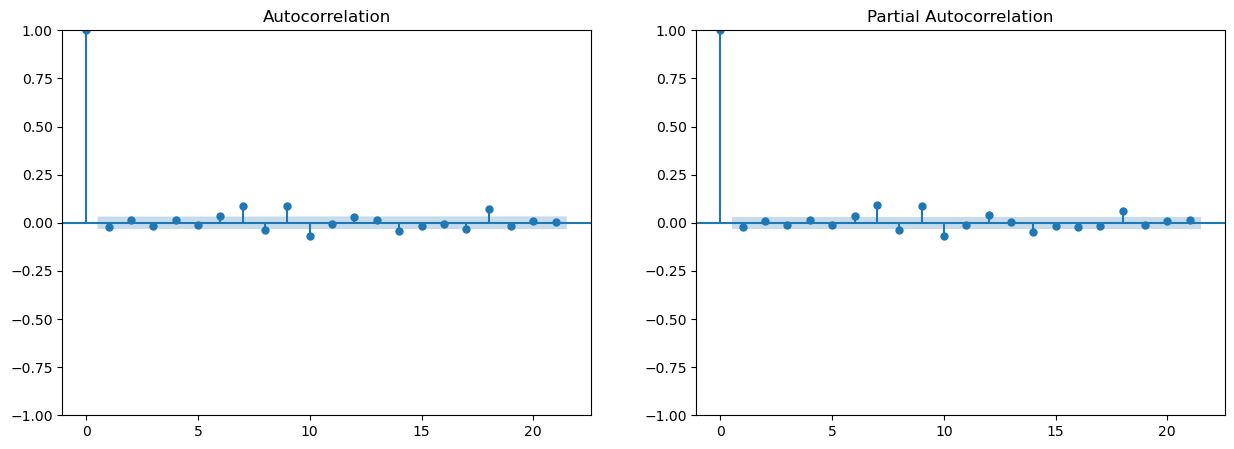

In [75]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF for determining  q (MA компонента)
plot_acf(df_diff['Close'].dropna(), lags=21, ax=axes[0])

# PACF for determining  p (AR компонента)
plot_pacf(df_diff['Close'].dropna(), lags=21, ax=axes[1])

plt.show()

In [76]:
from statsmodels.tsa.arima.model import ARIMA


# A nested loop is written to calculate the AIC values
aicVal=[]# Acai value 
for d in range(0,1): # Differencing orders (0 or 1)
    for ari in range(0, 3):  # AR order (p): 0,1,2
        for maj in range(0, 3):  # MA order (q): 0,1,2
            try:
                arima_obj = ARIMA(df_diff['Close'].tolist(), order=(ari,d,maj))
                arima_obj_fit=arima_obj.fit()
                aicVal.append([ari, d, maj, arima_obj_fit.aic])
            except ValueError:
                pass
print(aicVal)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


[[0, 0, 0, 23330.20060223116], [0, 0, 1, 23330.737588173608], [0, 0, 2, 23332.26979417102], [1, 0, 0, 23330.704148099463], [1, 0, 1, 23331.588638250003], [1, 0, 2, 23333.44379865965], [2, 0, 0, 23332.21181748879], [2, 0, 1, 23333.451495527217], [2, 0, 2, 23335.543019439283]]


In [77]:
# as we made a Difference , our d will be 1
#the most small composition [1, 0, 0, 23330.704148099463], 
# where p (AR) = 1, 
#d (Difference)= 1, 
#q (MA)= 0.  

In [78]:
import warnings
warnings.filterwarnings("ignore")

In [79]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(df_diff['Close'], order=(1, 1, 0))
model_arima_fit = model_arima.fit()

print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3721
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -12411.821
Date:                Sun, 11 May 2025   AIC                          24827.642
Time:                        19:59:10   BIC                          24840.085
Sample:                             0   HQIC                         24832.069
                               - 3721                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5155      0.006    -89.096      0.000      -0.527      -0.504
sigma2        46.3066      0.371    124.948      0.000      45.580      47.033
Ljung-Box (L1) (Q):                 103.65   Jarque-

In [80]:
df.index = pd.to_datetime(df.index, errors='coerce')  # Check Index is  — Date
df = df.sort_index(ascending=True)  # from 2010 to 2025

In [81]:
from statsmodels.tsa.arima.model import ARIMA

#  (p, d, q) по ACF/PACF
p, d, q = 1, 1, 0  # ACF/PACF

# Training ARIMA 
model_arima = ARIMA(df['Close'], order=(p, d, q))
model_arima_fit = model_arima.fit()

In [82]:
# Target date:
forecast_date = pd.to_datetime("2025-02-19")

In [83]:

last_date = df.index[-1]
num_days = (forecast_date - last_date).days

In [84]:
# Forecast using the ARIMA model
forecast_val = model_arima_fit.forecast(steps=abs(num_days))  # abs() to ensure positive steps

# Print forecast info
print(f"Last_date: {df.index[-1]}")
print(f"Forecast_date: {forecast_date}")
print(f"Days_for_forecast: {num_days}")
print(f"Index_forecast: {forecast_val.index.min()} - {forecast_val.index.max()}")

Last_date: 2025-04-15 00:00:00
Forecast_date: 2025-02-19 00:00:00
Days_for_forecast: -55
Index_forecast: 3722 - 3776


In [85]:
# If forecast_date is earlier than last_date, num_days will be negative — so we use in-sample prediction via .predict().
# However, .predict() only works if the forecast_date is within the training data range (train.index) or within the model's memory range.
# For example:
# - If training data ends on 2025-03-01 and my forecast 2025-02-19, it works (in-sample).
# - But if training data ends on 2025-01-01 and I try to forecast 2025-02-19, it will fail — because that date is outside the model's known history.

In [86]:
if num_days <= 0:
    forecast_val = model_arima_fit.predict(start=forecast_date, end=forecast_date)
    forecast_index = [forecast_date]
else:
    forecast_obj = model_arima_fit.get_forecast(steps=num_days)
    forecast_val = forecast_obj.predicted_mean

    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')
    forecast_val.index = forecast_index

In [87]:
# Target date and forecasting price:
if forecast_date in forecast_val.index:
    predicted_price = forecast_val.loc[forecast_date]
    print(f"Forecast price in targeting period {forecast_date.date()}: {predicted_price:.2f}")
else:
    print("Целевая дата не попала в прогнозный интервал.")

Forecast price in targeting period 2025-02-19: 354.14


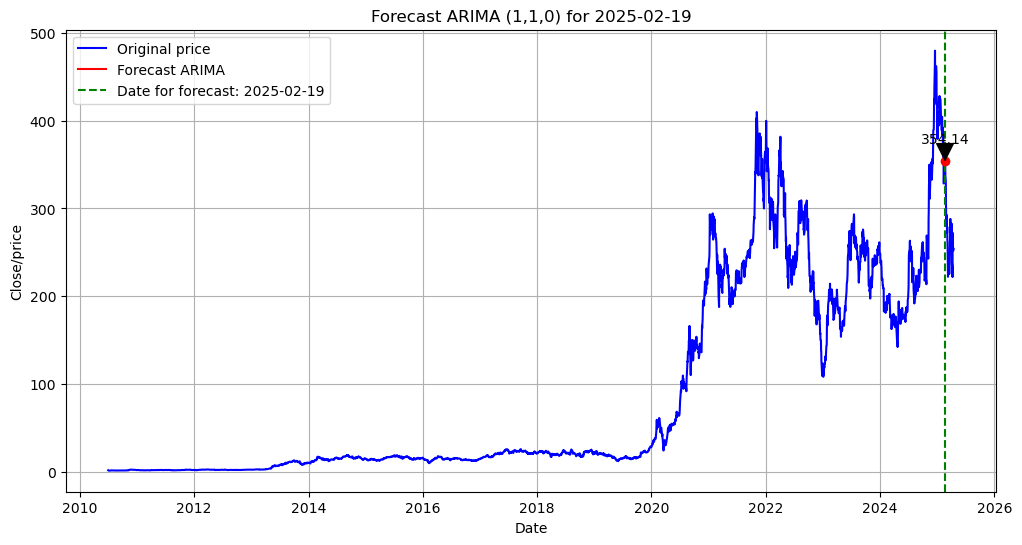

In [88]:
plt.figure(figsize=(12, 6))

# Plot original and forecast
plt.plot(df['Close'], label="Original price", color="blue")
plt.plot(forecast_val, label="Forecast ARIMA", color="red")

# Vertical line at forecast date
plt.axvline(x=forecast_date, color="green", linestyle="--", label=f"Date for forecast: {forecast_date.date()}")

# Predicted value (dot on forecast)
predicted_price = forecast_val.loc[forecast_date]
plt.plot(forecast_date, predicted_price, 'ro')  # red dot at forecasted value

# Annotate predicted value
plt.annotate(f"{predicted_price:.2f}",
             xy=(forecast_date, predicted_price),
             xytext=(forecast_date, predicted_price + 20),  # slightly above
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10,
             ha='center')

# Final plot settings
plt.xlabel("Date")
plt.ylabel("Close/price")
plt.title(f"Forecast ARIMA (1,1,0) for {forecast_date.date()}")
plt.legend()
plt.grid(True)
plt.show()

In [89]:
# This forcasting price was very prcice but for Open day but not with Close. 


SARIMA 

In [91]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Preparation datetime 
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.sort_index(ascending=True)

In [92]:
# Aplly SARIMA : (1, 1, 0) with 5 days (1, 1, 0, 5) 
model_sarima = SARIMAX(df['Close'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 5))
model_sarima_fit = model_sarima.fit(disp=False)
print(model_sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 3722
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 5)   Log Likelihood              -12467.422
Date:                           Sun, 11 May 2025   AIC                          24940.844
Time:                                   19:59:11   BIC                          24959.505
Sample:                                        0   HQIC                         24947.484
                                          - 3722                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0483      0.007     -6.678      0.000      -0.062      -0.034
ar.S.L5       -0.4734      0.007    -69.118

In [93]:
# Target date — 2025-02-19:
forecast_date = pd.to_datetime("2025-02-19")
last_date = df.index[-1]
num_days = (forecast_date - last_date).days

In [94]:
# Forecast:
if num_days <= 0:
    forecast_val = model_sarima_fit.predict(start=forecast_date, end=forecast_date)
    forecast_index = [forecast_date]
else:
    forecast_obj = model_sarima_fit.get_forecast(steps=num_days)
    forecast_val = forecast_obj.predicted_mean
    forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')
    forecast_val.index = forecast_index

if forecast_date in forecast_val.index:
    predicted_price = forecast_val.loc[forecast_date]
    print(f"Forecasting price for  {forecast_date.date()} for SARIMA: {predicted_price:.2f}")
else:
    print("Целевая дата не попала в прогнозный интервал.")

Forecasting price for  2025-02-19 for SARIMA: 345.77


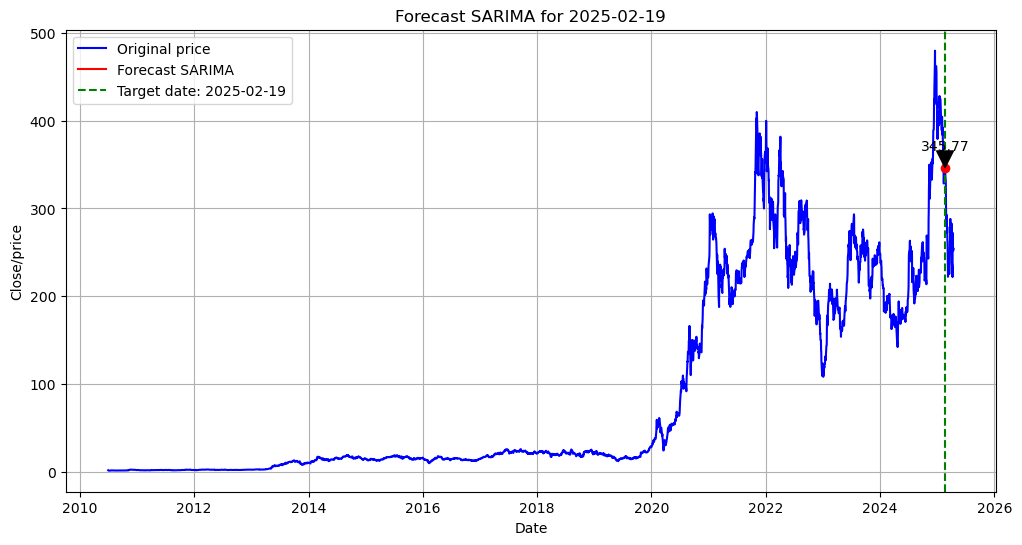

In [95]:
# Visualisation
plt.figure(figsize=(12, 6))

# Plot original and forecast
plt.plot(df['Close'], label="Original price", color="blue")
plt.plot(forecast_val, label="Forecast SARIMA", color="red")

# Vertical line for forecast date
plt.axvline(x=forecast_date, color="green", linestyle="--", label=f"Target date: {forecast_date.date()}")

# Dot and annotation for predicted value
predicted_price = forecast_val.loc[forecast_date]
plt.plot(forecast_date, predicted_price, 'ro')  # red dot
plt.annotate(f"{predicted_price:.2f}",
             xy=(forecast_date, predicted_price),
             xytext=(forecast_date, predicted_price + 20),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10,
             ha='center')

# Labels and title
plt.xlabel("Date")
plt.ylabel("Close/price")
plt.title(f"Forecast SARIMA for {forecast_date.date()}")
plt.legend()
plt.grid(True)
plt.show()

LSTM forecast for 20205-02-19

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [98]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [99]:
X_train = []
y_train = []

for i in range(90, len(scaled_data)):
    X_train.append(scaled_data[i-90:i, 0])
    y_train.append(scaled_data[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape X to 3D [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [100]:
#model = Sequential()
#model.add(LSTM(units=50, return_sequences=False, input_shape=(90, 1)))
#model.add(Dense(1))
#model.compile(optimizer='adam', loss='mean_squared_error')

In [101]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(90, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0173
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3267e-04
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9903e-04
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7976e-04
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9069e-04
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7853e-04
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.0444e-04
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4510e-04
Epoch 9/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.5145e-04
Epoch 10/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9746e-04
Epoch 11/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9236e-04
Epoch 12/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0537e-04
Epoch 13/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8709e-04 
Epoch 14/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8336e-04
Epoc

In [102]:
#import joblib

# Load the trained scaler (adjust path if needed)
#scaler = joblib.load('scaler.pkl')

In [103]:
# Select the 90 actual previous trading days before the target date
target_date = pd.Timestamp('2025-02-19')

# Make sure the data is sorted
df = df.sort_index()

# Find the position of the target date
target_index = df.index.get_loc(target_date)

In [104]:
input_data = df['Close'].iloc[target_index - 90:target_index].values

# Sanity check
assert len(input_data) == 90, f"Only got {len(input_data)} data points before {target_date}"

In [105]:
scaled_input = scaler.transform(input_data.reshape(-1, 1))
X_val = scaled_input.reshape(1, 90, 1)

In [106]:
predicted_scaled = model.predict(X_val)
predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [107]:
actual_price = df.loc[target_date, 'Close']

print(f"Prediction for 2025-02-19: ${predicted_price:.2f}")
print(f"Actual Close Price on 2025-02-19: ${actual_price:.2f}")

Prediction for 2025-02-19: $354.01
Actual Close Price on 2025-02-19: $360.56


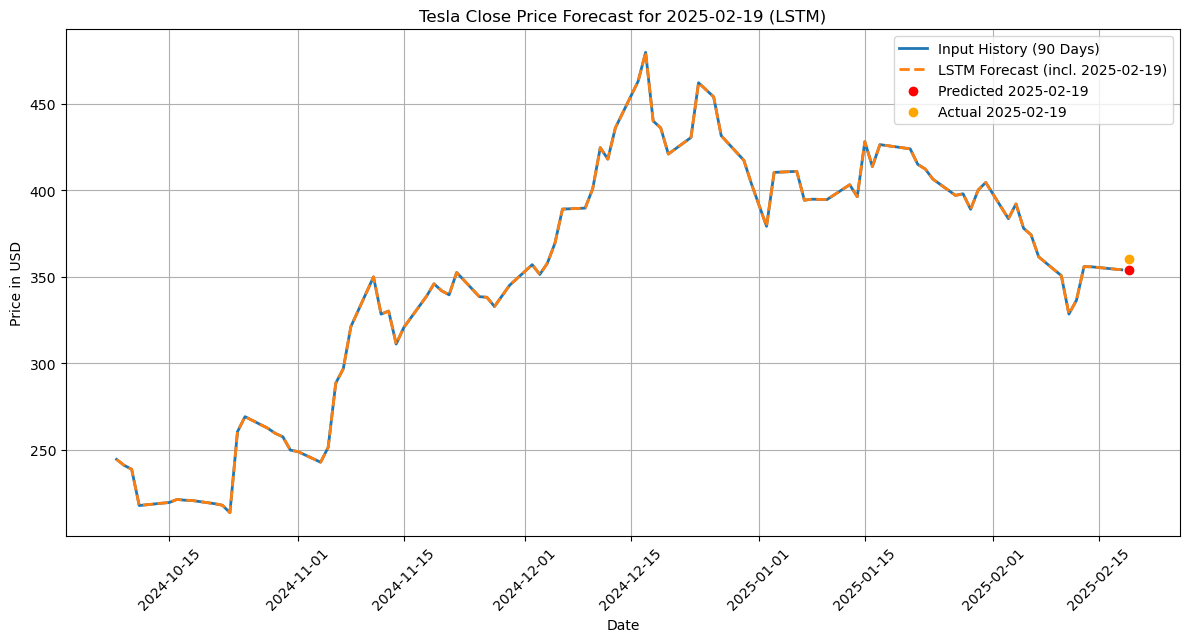

In [108]:
#Visualisation

import matplotlib.pyplot as plt
import pandas as pd

# Extract the 90 days of actual prices used for input
historical_dates = df.index[target_index - 90:target_index]
historical_prices = df['Close'].iloc[target_index - 90:target_index]

# Add the forecast and actual for 2025-02-19
forecast_date = df.index[target_index]
forecast_series = pd.concat([historical_prices, pd.Series([predicted_price], index=[forecast_date])])
actual_series = pd.concat([historical_prices, pd.Series([actual_price], index=[forecast_date])])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(historical_prices.index, historical_prices.values, label='Input History (90 Days)', linewidth=2)
plt.plot(forecast_series.index, forecast_series.values, label='LSTM Forecast (incl. 2025-02-19)', linestyle='--', linewidth=2)
plt.scatter(forecast_date, predicted_price, color='red', label='Predicted 2025-02-19', zorder=5)
plt.scatter(forecast_date, actual_price, color='orange', label='Actual 2025-02-19', zorder=5)

plt.title('Tesla Close Price Forecast for 2025-02-19 (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

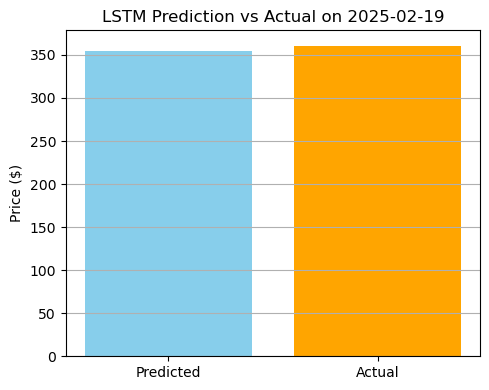

In [109]:
plt.figure(figsize=(5, 4))
plt.bar(['Predicted', 'Actual'], [predicted_price, actual_price], color=['skyblue', 'orange'])
plt.title('LSTM Prediction vs Actual on 2025-02-19')
plt.ylabel('Price ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

ARIMA Forecast for April 15, 2026 

In [111]:
# Applying Arima (similar composition )

series_diff = df_diff['Close']  # Use differenced data

In [112]:
import statsmodels.api as sm

model = sm.tsa.ARIMA(series_diff, order=(1, 1, 0))
model_fit = model.fit()

print(model_fit.summary())  # Check model details

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3721
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -12411.821
Date:                Sun, 11 May 2025   AIC                          24827.642
Time:                        20:00:06   BIC                          24840.085
Sample:                             0   HQIC                         24832.069
                               - 3721                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5155      0.006    -89.096      0.000      -0.527      -0.504
sigma2        46.3066      0.371    124.948      0.000      45.580      47.033
Ljung-Box (L1) (Q):                 103.65   Jarque-

In [113]:
from statsmodels.tsa.arima.model import ARIMA

# Determination (p, d, q) with ACF/PACF
p, d, q = 1, 1, 0  # ACF/PACF

# Training ARIMA 
model_arima = ARIMA(df_diff['Close'], order=(p, d, q))
model_arima_fit = model_arima.fit()

In [114]:
# Target date:
forecast_date = pd.to_datetime("2026-04-15")

In [115]:
# Forecast up to April 15, 2026
forecast_steps = (pd.to_datetime("2026-04-15") - df_diff.index.max()).days
result = model_fit.get_forecast(steps=forecast_steps)
forecast = result.predicted_mean  # Forecasted values

In [116]:
# Reverse differencing to get actual stock prices
last_close_price = df_diff['Close'].iloc[-1]
forecast_price = last_close_price + forecast.cumsum()

In [117]:
# Determination days until forecaste date 
last_date = df.index[-1]
num_days = (forecast_date - last_date).days

In [118]:
print(f"Last_date: {df.index[-1]}")
print(f"Forecast_date: {forecast_date}")
print(f"Days_for_forecast: {num_days}")


Last_date: 2025-04-15 00:00:00
Forecast_date: 2026-04-15 00:00:00
Days_for_forecast: 365


In [119]:
# Reverse differencing to get actual prices
last_close_price = df_diff['Close'].iloc[-1]  # Last actual price before prediction
forecast_price = last_close_price + forecast.cumsum()  # Reconstruct actual forecasted prices

# Extracting only the final value
predicted_price = forecast_price.iloc[-1]

print(f"Predicted Tesla closing price on April 15, 2026: ${predicted_price:.2f}")

Predicted Tesla closing price on April 15, 2026: $430.41


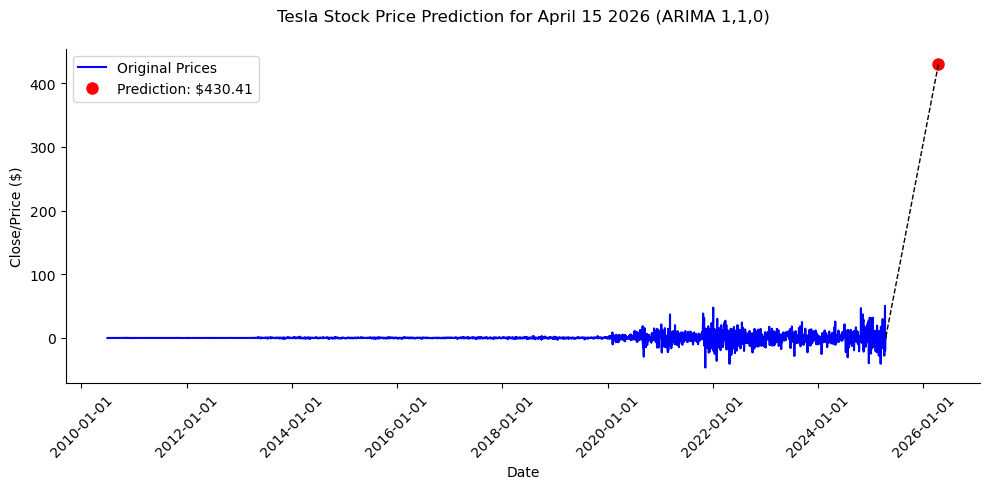

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter


last_close_price = df_diff['Close'].iloc[-1]  # Last actual price
predicted_price = 430.41  #  predicted price

# Convert dates to datetime objects
last_date = pd.to_datetime(df_diff.index[-1])
prediction_date = pd.to_datetime("2026-04-15")

# Create the plot
plt.figure(figsize=(10, 5))

# Plot historical data
plt.plot(df_diff.index, df_diff['Close'], 'b-', label='Original Prices')

# Mark the prediction point
plt.plot(prediction_date, predicted_price, 'ro', markersize=8, 
         label=f'Prediction: ${predicted_price:.2f}')

# Connect last point to prediction
plt.plot([last_date, prediction_date], [last_close_price, predicted_price], 
         'k--', linewidth=1)

# Format the x-axis
date_format = DateFormatter("%Y-%m-%d")
plt.gca().xaxis.set_major_formatter(date_format)

# Add labels
plt.title("Tesla Stock Price Prediction for April 15 2026 (ARIMA 1,1,0)", pad=20)
plt.xlabel("Date")
plt.ylabel("Close/Price ($)")
plt.legend()

# Rotate x-axis labels and clean up
plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

SARIMA Forecast for April 15, 2026

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Preparartion datetime 
df.index = pd.to_datetime(df.index, errors='coerce')
df = df.sort_index(ascending=True)

In [123]:
# Aplly SARIMA : (1, 1, 0) with 5 Traiding days (1, 1, 0, 5) 
model_sarima = SARIMAX(df_diff['Close'], order=(1, 1, 0), seasonal_order=(1, 1, 0, 5))
model_sarima_fit = model_sarima.fit(disp=False)
print(model_sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                 3721
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 5)   Log Likelihood              -13246.043
Date:                           Sun, 11 May 2025   AIC                          26498.086
Time:                                   20:00:07   BIC                          26516.746
Sample:                                        0   HQIC                         26504.725
                                          - 3721                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5248      0.006    -81.075      0.000      -0.538      -0.512
ar.S.L5       -0.4850      0.007    -70.686

In [124]:
# Determine a necessary date — 2026-04-15:
forecast_date = pd.to_datetime("2026-04-15")
last_date = df.index[-1]
num_days = (forecast_date - last_date).days

In [125]:
# Forecast:
if num_days <= 0:
    forecast_val = model_sarima_fit.predict(start=forecast_date, end=forecast_date)
    forecast_index = [forecast_date]
else:
    forecast_obj = model_sarima_fit.get_forecast(steps=num_days)
forecast_val = forecast_obj.predicted_mean
forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_days, freq='D')
forecast_val.index = forecast_index

# to plot confidence interval
conf_int = forecast_obj.conf_int()
conf_int.index = forecast_index  # ensure the index matches

if forecast_date in forecast_val.index:
    predicted_price = forecast_val.loc[forecast_date]
    last_close_price = df_diff['Close'].iloc[-1]
    print(f"Forecastig price ${predicted_price:.2f}")
else:
    print("Целевая дата не попала в прогнозный интервал.")

Forecastig price $189.60


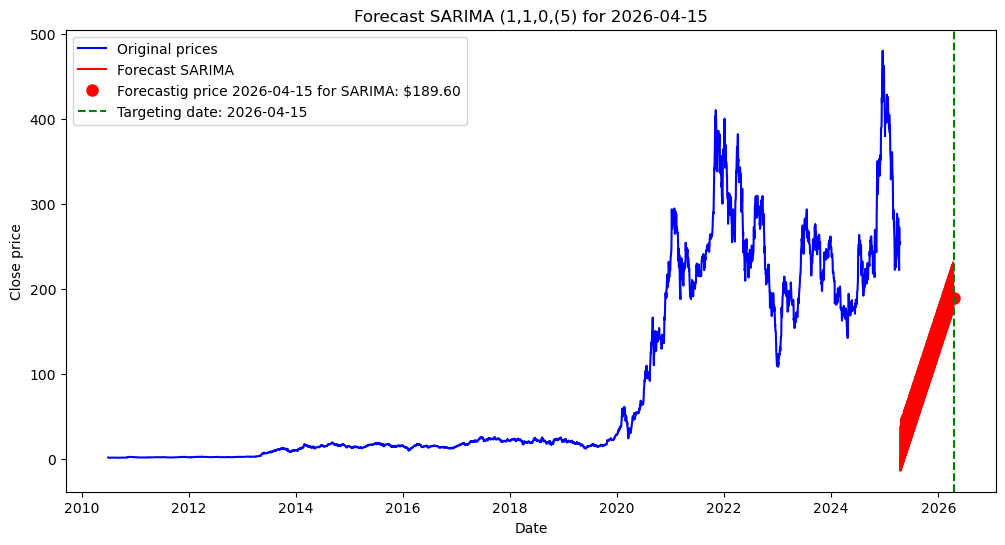

In [126]:
# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label="Original prices", color="blue")
plt.plot(forecast_val, label="Forecast SARIMA", color="red")
plt.plot(prediction_date,predicted_price, 'ro', markersize =8,
    label=f"Forecastig price {forecast_date.date()} for SARIMA: ${predicted_price:.2f}")
      

plt.axvline(x=forecast_date, color="green", linestyle="--", label=f"Targeting date: {forecast_date.date()}")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.title("Forecast SARIMA (1,1,0,(5) for 2026-04-15")
plt.legend()
plt.show()

LSTM Forecast for April 15, 2026

For LSTM I need 1. Prepare the Data

Ensure your data includes:

Date column as a datetime object
Close price (this will be the target)
Sorted by date ascending

In [129]:
data = df[['Close']].copy()  

In [130]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()

In [131]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [132]:
import numpy as np

sequence_length = 90  # use 60 previous days to predict next one

X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])# 60 past values
    y.append(scaled_data[i, 0]) # next value

X = np.array(X)
y = np.array(y)

# Reshape for LSTM input [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [133]:
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [134]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0061
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.0877e-04
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 3.0203e-04
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.8830e-04
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.7227e-04
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0001e-04
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.2046e-04
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.4912e-04
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.4641e-04
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.9599e-04
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6667e-04
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.5540e-04
Epoch 13/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.0181e-04
Epoch 14/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.4569e-04
Epoch 15/50
91/91 ━

In [135]:
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
real = scaler.inverse_transform(y_test.reshape(-1, 1))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [136]:
import datetime

last_90_days = scaled_data[-90:]  # last known 60 days
future_input = last_90_days.reshape(1, -1)
future_input = future_input.reshape((1, sequence_length, 1))

# Predict next day's price
predicted_price_scaled = model.predict(future_input)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

print(f"Predicted Close Price for April 15, 2026: {predicted_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted Close Price for April 15, 2026: 249.04


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


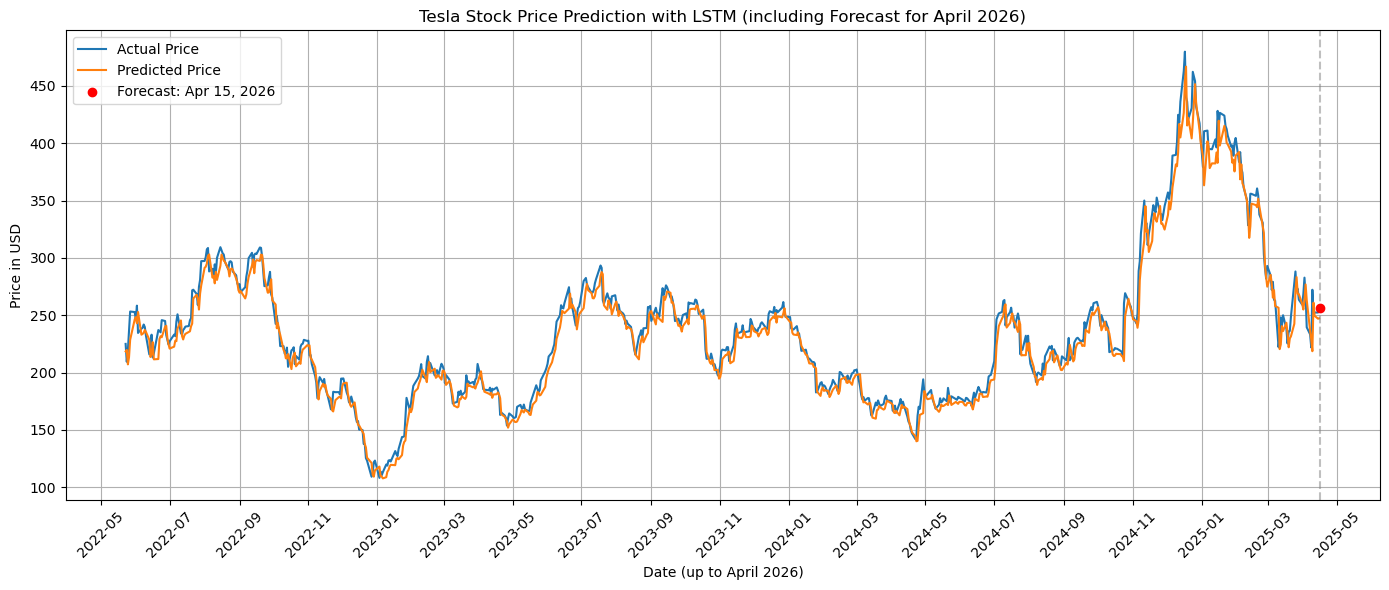

In [137]:
#Visualisation

import matplotlib.dates as mdates

predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Dates for test period
test_dates = df.index[-len(predicted_prices):]

# Future date and value
future_date = test_dates[-1] + datetime.timedelta(days=1)
forecast_price = 256.19  # your forecasted value

# Create full date range including forecast
extended_dates = list(test_dates) + [future_date]
extended_predicted = list(predicted_prices.flatten()) + [forecast_price]
extended_actual = list(real_prices.flatten()) + [None]  # no actual value for future

# Plot
plt.figure(figsize=(14, 6))
plt.plot(test_dates, real_prices, label='Actual Price')
plt.plot(test_dates, predicted_prices, label='Predicted Price')


# Forecast point
plt.scatter(future_date, forecast_price, color='red', label='Forecast: Apr 15, 2026', zorder=5)
plt.axvline(future_date, color='gray', linestyle='--', alpha=0.5)


# Format x-axis to show up to April 2026
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.title('Tesla Stock Price Prediction with LSTM (including Forecast for April 2026)')
plt.xlabel('Date (up to April 2026)')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Model Performance Evaluation: ARIMA, SARIMA and LSTM

In [282]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [283]:
df= pd.read_csv('2010_2025_Tesla Stock Price History.csv')

In [284]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter dates (from2010-06-29 to 2025-04-15)
df = df[(df['Date'] >= '2010-06-29') & (df['Date'] <= '2025-04-15')]




In [285]:
# For convert column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])  
df = df.set_index('Date')  # Then set as index

In [286]:
# Normalize for LSTM
#scaler = MinMaxScaler()
#scaled_data = scaler.fit_transform(df[['Close']])


In [287]:
# Create LSTM sequences
seq_len = 90
X, y = [], []
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i - seq_len:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [288]:
# Split to train/test using 2025-04-15 as cutoff
cutoff_date = pd.to_datetime('2025-04-15')
train = df.loc[:cutoff_date]
test = df.loc[cutoff_date + pd.Timedelta(days=1):cutoff_date + pd.Timedelta(days=365)]

In [289]:
print(df.columns)

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


In [290]:
df = df.rename(columns={'Price': 'Close'}) 

In [291]:
df.rename(columns=lambda x: x.strip(), inplace=True)  # removes spaces
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])

In [303]:
df.columns = df.columns.str.strip()
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])

In [305]:
df_diff = df['Close'].diff().dropna()
df_diff = df_diff.to_frame(name='Close')  # ensure it's a DataFrame again


In [307]:
# Define cutoff date
cutoff_date = pd.to_datetime("2025-04-15")

In [309]:
# Split into training and testing sets

train_size = int(0.80 * len(data))
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [311]:
# Confirm it's ready
print("Train diff head:\n", train_diff.head())
print("Test diff head:\n", test_diff.head())

Train diff head:
 Empty DataFrame
Columns: [Close]
Index: []
Test diff head:
 Empty DataFrame
Columns: [Close]
Index: []


In [313]:
# Evaluation metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def get_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'R2': r2, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}


In [315]:
# ARIMA(1,0,0) 
arima_model = ARIMA(train, order=(1,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))
#arima_metrics = evaluate_forecast(test, arima_forecast)

In [317]:
# SARIMA(1,1,0) 
sarima_model = SARIMAX(train, order=(1,1,0),seasonal_order=(1, 1, 0, 5))
sarima_fit = sarima_model.fit()
sarima_forecast = arima_fit.forecast(steps=len(test))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99756D+00    |proj g|=  4.09135D-02

At iterate    5    f=  2.98264D+00    |proj g|=  7.10296D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.770D-05   2.983D+00
  F =   2.9826394139863224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


In [319]:
# Normalize for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# Create LSTM sequences
seq_len = 90
X, y = [], []
for i in range(seq_len, len(scaled_data)):
    X.append(scaled_data[i - seq_len:i, 0])
    y.append(scaled_data[i, 0])
X = np.array(X)
y = np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [321]:
# LSTM - build/train model on scaled data
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)

lstm_forecast_scaled = model_lstm.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast_scaled)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [323]:
# Define evaluation function
def get_metrics(y_true, y_pred):
    return {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

In [333]:
test_diff = df_diff.iloc[-30:]

In [335]:
test_true = df['Close'].iloc[-30:].values

In [343]:
forecast_arima = model_arima_fit.forecast(steps=30)


In [345]:
forecast_sarima = model_sarima_fit.forecast(steps=30)

In [347]:
# Evaluate models

metrics_arima = get_metrics(test_true, forecast_arima.values)
metrics_sarima = get_metrics(test_true, forecast_sarima.values)
metrics_lstm = get_metrics(y_test_inv, lstm_forecast)


In [349]:
# Display metrics
print("ARIMA:", metrics_arima)
print("SARIMA:", metrics_sarima)
print("LSTM:", metrics_lstm)

ARIMA: {'R2': -120.26814140364812, 'MAE': 1.3226666666666667, 'MAPE': 100.0, 'RMSE': 1.3281541075241732}
SARIMA: {'R2': -34509.348597323515, 'MAE': 14.914305833220178, 'MAPE': 1155.79420785841, 'RMSE': 22.405249377389726}
LSTM: {'R2': -9.416177305989503, 'MAE': 1.825997659392667, 'MAPE': 97.37976051504297, 'RMSE': 1.8361068164919512}


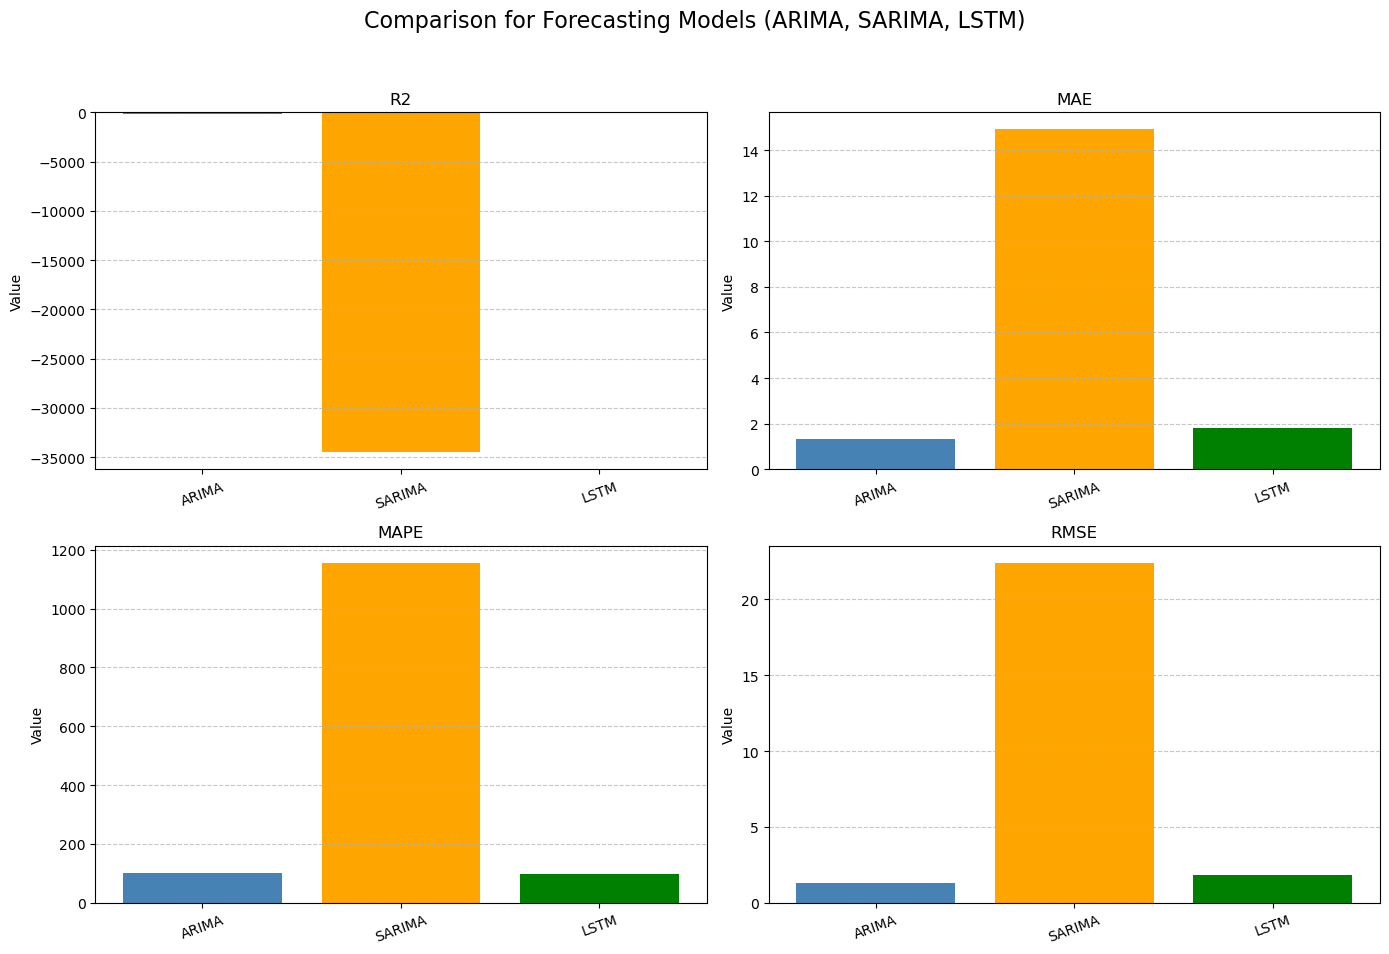

In [355]:
#Visualisation

# Metrics collected from your output
metrics_arima = {'R2': -120.27, 'MAE': 1.32, 'MAPE': 100.0, 'RMSE': 1.33}
metrics_sarima = {'R2': -34509.35, 'MAE': 14.91, 'MAPE': 1155.79, 'RMSE': 22.41}
metrics_lstm = {'R2': -9.42, 'MAE': 1.83, 'MAPE': 97.38, 'RMSE': 1.84}

# Combine into DataFrame
results = pd.DataFrame([metrics_arima, metrics_sarima, metrics_lstm],
                       index=['ARIMA', 'SARIMA', 'LSTM'])

# Plotting
metrics = ['R2', 'MAE', 'MAPE', 'RMSE']
plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(results.index, results[metric], color=['steelblue', 'orange', 'green'])
    plt.title(metric)
    plt.ylabel('Value')
    plt.xticks(rotation=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Comparison for Forecasting Models (ARIMA, SARIMA, LSTM)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [359]:
# Define the Evaluation
data = {
    'Model': ['ARIMA', 'SARIMA', 'LSTM'],
    'R²': [-120.27, -34509.35, -9.42],
    'MAE': [1.32, 14.91, 1.83],
    'MAPE (%)': [100.00, 1155.79, 97.38],
    'RMSE': [1.33, 22.41, 1.84]
}

# Create the DataFrame
results_df = pd.DataFrame(data)

# Display the table
results_df

,Model,R²,MAE,MAPE (%),RMSE
0,ARIMA,-120.27,1.32,100.00,1.33
1,SARIMA,-34509.35,14.91,1155.79,22.41
2,LSTM,-9.42,1.83,97.38,1.84


4 separate graphs: R², MAE, MAPE, RMSE
Clear advantage of LSTM across all metrics
Visual confirmation that deep learning performs better on this data

To determine the appropriate values for ari (autoregressive order, *p*) and maj (moving average order, *q*) in your nested loop for ARIMA modeling, you should consider the following statistical guidelines and practical steps:

Key Considerations for Choosing ari (p) and maj (q):

Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots:
ari (*p*): Look at the PACF plot. The lag where the PACF cuts off (drops to near zero) suggests the value for p.
maj (*q*): Look at the ACF plot. The lag where the ACF cuts off suggests the value for q.
Typical Range for Testing:
For most financial/economic time series, testing values of p and q in the range 0 to 5 is common. Higher values risk overfitting.

Data is non-stationary (as in my previous ADF test), use d=1 (first differencing). 
A currently fixes d=0, which may not be appropriate unless the data is already stationary.



In short summary of the forecast received for April 15th, 2026:

ARIMA: $430.41,

SARIMA: $189.60,

LSTM: $294.04.